# Test learning capacity
In this notebook we will test whether the generator structure can actually learn. Use a simple example from Pytorch.
See [source](https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe).


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import math
import threading
import logging
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

import matplotlib.pyplot as plt
from os import system
import time

In [32]:
dims = 4
samples = 250
addit = 2.4
X1 = torch.randn(samples, dims)
X2 = torch.randn(samples, dims) + addit
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(samples, 1)
Y2 = torch.ones(samples, 1)
Y = torch.cat([Y1, Y2], dim=0)

print(X.size())
print(Y.size())

torch.Size([500, 4])
torch.Size([500, 1])


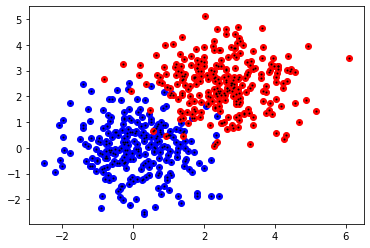

In [33]:
plt.scatter(X1[:, 0], X1[:, 1], color='b')
plt.scatter(X2[:, 0], X2[:, 1], color='r')
plt.scatter(X[:, 0], X[:, 1], color='k', s=1)
plt.title()

In [75]:
#from Polytion import Generator as g
from Polytion.Generator import PolyganCPlayer_seq
from Polytion.Generator import PolyclassFTTlayer_seq

Here is Sequential Generator without upsampling:

In [5]:
class Generator_seq(torch.nn.Module):
    def __init__(self, layer, N, rank, imwidth, imheight, scalefactor, layeroptions, generatoroptions):
        super(Generator_seq, self).__init__()
        # Channels: here we are working with greyscale images
        self.c = 1
        self.imwidth, self.imheight = imwidth, imheight
        self.s = imwidth*imheight
        self.PolyLayer = layer(N, rank, imwidth, imheight, layeroptions)
        self.BN = torch.nn.BatchNorm2d(num_features=1)
        #self.upsample = torch.nn.Upsample(scale_factor=scalefactor, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Register dimensions:
        xshape = x.shape
        if len(xshape) == 2:
            self.batch_size = 1
        else:
            self.batch_size = xshape[0]

        # Register x as attribute for parallel access, and clone because dataset would be overwritten
        #self.x = self.BN(x.clone())
        self.x = x.clone()
        #self.x = self.upsample(self.x)
        self.x = self.x.reshape(self.batch_size, self.c, self.s)
        self.x = self.PolyLayer(self.x, self.batch_size)

        self.x = self.x.reshape(self.batch_size, self.c, self.imwidth, self.imheight)
        return self.x


In [84]:
# Make the 'generator' network: in this case to be used as a feed forward network
batch_size = 100
N = 10
rank = 30
imwidth, imheight = int(dims/2), int(dims/2)
#layer = PolyganCPlayer_seq
layer = PolyclassFTTlayer_seq

generatorOptions = {'parallel':False, 'workers':10}
layerOptions = {'randnormweights':False, 'normalize':False, 'parallel':False}

net = Generator_seq(layer, N, rank, imwidth, imheight, 1, layerOptions, generatorOptions)

opt = torch.optim.Adam(net.parameters(), lr=0.0005)

#criterion = nn.BCELoss()
criterion = nn.MSELoss()

In [70]:
def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    epochloss = 0
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
        y_batch = Y[beg_i:beg_i + batch_size, :]

        #x_batch = Variable(x_batch, requires_grad=True)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # Reformat output of the network when using the .py file (output is not formatted for binary classification:
        y_hat = y_hat.reshape(batch_size, -1)
        y_hat = y_hat.sum(1)
        y_hat = torch.sigmoid(y_hat)
        y_batch = y_batch[:, 0]
        
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        epochloss += loss.detach().numpy()
        losses.append(loss.detach().numpy())
    return epochloss

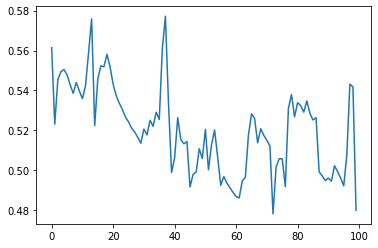

In [88]:
e_losses = []
num_epochs = 100
for e in range(num_epochs):
    print("epoch", e+1, end='\r')
    e_losses.append(train_epoch(net, opt, criterion, batch_size))

plt.plot(e_losses);

system('say complete');

In [86]:
timestamp = time.strftime("%d-%m-%Y_%H:%M:%S")

# Test it out
X_1 = torch.randn(samples, dims)
X_2 = torch.randn(samples, dims) + addit
X_t = torch.cat([X_1, X_2], dim=0)

Y1 = torch.zeros(samples)
Y2 = torch.ones(samples)
true = torch.cat([Y1, Y2], dim=0)


net.eval()
results = torch.zeros(X_t.shape[0])
for beg_i in range(0, X_t.size(0), batch_size):
    x_batch = X_t[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
    results[beg_i:beg_i + batch_size] = net(x_batch).reshape(batch_size, -1).sum(1)

results = torch.round(torch.sigmoid(results))

X1_t = torch.where(results == 0)[0]
X2_t = torch.where(results == 1)[0]

correct_results_sum = (results == true).sum().float()
acc = correct_results_sum/true.shape[0]
acc = torch.round(acc * 100)
print("Accuracy score: ", acc.item())

Accuracy score:  76.0


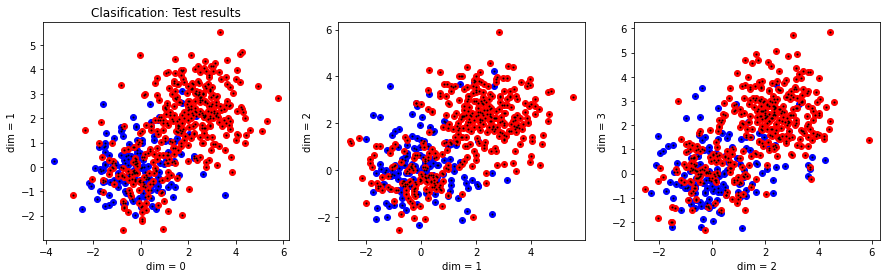

In [89]:
Xd = X_t.detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].scatter(Xd[X1_t, 0], Xd[X1_t, 1], color='b')
ax[0].scatter(Xd[X2_t, 0], Xd[X2_t, 1], color='r')
ax[0].scatter(Xd[:, 0], Xd[:, 1], color='k', s=1)
ax[0].set_xlabel('dim = 0')
ax[0].set_ylabel('dim = 1')

ax[1].scatter(Xd[X1_t, 1], Xd[X1_t, 2], color='b')
ax[1].scatter(Xd[X2_t, 1], Xd[X2_t, 2], color='r')
ax[1].scatter(Xd[:, 1], Xd[:, 2], color='k', s=1)
ax[1].set_xlabel('dim = 1')
ax[1].set_ylabel('dim = 2')


ax[2].scatter(Xd[X1_t, 2], Xd[X1_t, 3], color='b')
ax[2].scatter(Xd[X2_t, 2], Xd[X2_t, 3], color='r')
ax[2].scatter(Xd[:, 2], Xd[:, 3], color='k', s=1)
ax[2].set_xlabel('dim = 2')
ax[2].set_ylabel('dim = 3')

ax[0].set_title('Clasification: Test results')
plt.show()

#plotting
# filename = "Polytion/Polynomial_generator_exploration/" + timestamp + ".png"
# fig.savefig(filename, bbox_inches='tight')

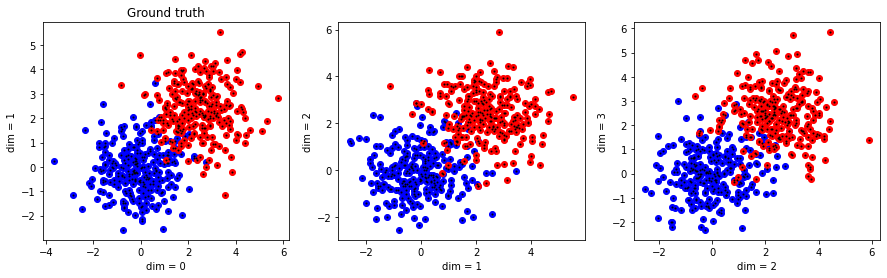

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].scatter(X_1[:, 0], X_1[:, 1], color='b')
ax[0].scatter(X_2[:, 0], X_2[:, 1], color='r')
ax[0].scatter(Xd[:, 0], Xd[:, 1], color='k', s=1)
ax[0].set_xlabel('dim = 0')
ax[0].set_ylabel('dim = 1')

ax[1].scatter(X_1[:, 1], X_1[:, 2], color='b')
ax[1].scatter(X_2[:, 1], X_2[:, 2], color='r')
ax[1].scatter(Xd[:, 1], Xd[:, 2], color='k', s=1)
ax[1].set_xlabel('dim = 1')
ax[1].set_ylabel('dim = 2')


ax[2].scatter(X_1[:, 2], X_1[:, 3], color='b')
ax[2].scatter(X_2[:, 2], X_2[:, 3], color='r')
ax[2].scatter(Xd[:, 2], Xd[:, 3], color='k', s=1)
ax[2].set_xlabel('dim = 2')
ax[2].set_ylabel('dim = 3')

ax[0].set_title('Ground truth')
plt.show()

# Can we do better?
Perform a grid search:


In [ ]:

learning_rates = torch.logspace(-3, 0, 10)
batch_sizes = [50, 100, 250]
Ns = [i for i in range(3, 10)]
ranks = [2*i for i in range(2, 10)]

bestvals = {'N':0, 'rank':0, 'lr':0, 'BestLoss':100} 

for N in Ns:
    # safety pin: 
    break
    print("N =", N, end ='\r')
    for rank in ranks:
        print("rank =", rank, end ='\r')
        for learning_rate in learning_rates:
            print("learning_rate =", learning_rate.item(), end ='\r')

            net = PolyNet(FTT_Layer, N, rank, imwidth, imheight)
            opt = torch.optim.Adam(net.parameters(), lr=learning_rate.item())

            #train:
            e_losses = []
            num_epochs = 50
            for e in range(num_epochs):
                print('{0: <6}'.format('N = ' + str(N).zfill(2)), '{0: <6}'.format('rank = ' + str(rank).zfill(2)), '{0:25}'.format('learning_rate = ' + str(round(learning_rate.item(), 5))), '{0: <7}'.format('epoch = ' + str(e+1).zfill(2)), end='\r')
                #print("epoch", e+1, end='\r')
                try:
                    epoch = train_epoch(net, opt, criterion, batch_size)
                    e_losses.append(train_epoch(net, opt, criterion, batch_size))
                except KeyboardInterrupt:
                    raise
                except:
                    print("\n Epoch", e, "failed")
                    
            # Extract best losses:
            mid = int(num_epochs/2)
            if sum(e_losses[0:mid])/len(e_losses[0:mid]) < sum(e_losses[mid:-1])/len(e_losses[mid:-1]):
                # Then the loss did not decrease
                continue
            if e_losses[-1] < bestvals['BestLoss']:
                print("\n Found a loss of", e_losses[-1])
                bestvals['N'] = N
                bestvals['rank'] = rank
                bestvals['lr'] = learning_rate
                bestvals['BestLoss'] = e_losses[-1]

system('say grid search complete');
